In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [0]:
sess = tf.InteractiveSession()

In [8]:
#load 4000 of MNIST data for train and 400 for testing
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_full = x_train[:4000] / 255
y_full = y_train[:4000]
x_test = x_test[:400] /255
y_test = y_test[:400]
x_full.shape, y_full.shape, x_test.shape, y_test.shape

11493376/11490434 [==============================] - 0s 0us/step


((4000, 28, 28), (4000,), (400, 28, 28), (400,))

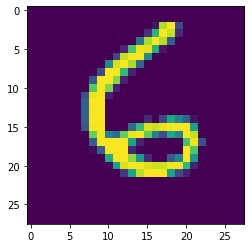

In [9]:
plt.imshow(x_full[3999])

In [0]:
#build computation graph
x = tf.placeholder(tf.float32, [None, 28, 28])
x_flat = tf.reshape(x, [-1, 28 * 28])
y_ = tf.placeholder(tf.int32, [None])
W = tf.Variable(tf.zeros([28 * 28, 10]), tf.float32)
b = tf.Variable(tf.zeros([10]), tf.float32)
y = tf.matmul(x_flat, W) + b
y_sm = tf.nn.softmax(y)
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_, logits=y))
train = tf.train.AdamOptimizer(0.1).minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(y_, tf.cast(tf.argmax(y, 1), tf.int32)), tf.float32))

In [0]:
def reset():
    '''Initialize data sets and session'''
    global x_labeled, y_labeled, x_unlabeled, y_unlabeled
    x_labeled = x_full[:0]
    y_labeled = y_full[:0]
    x_unlabeled = x_full
    y_unlabeled = y_full
    tf.global_variables_initializer().run()
    tf.local_variables_initializer().run() 

def fit():
    '''Train current labeled dataset until overfit.'''
    trial_count = 10
    acc = sess.run(accuracy, feed_dict={x:x_test, y_:y_test})
    weights = sess.run([W, b])
    while trial_count > 0:
        sess.run(train, feed_dict={x:x_labeled, y_:y_labeled})
        acc_new = sess.run(accuracy, feed_dict={x:x_test, y_:y_test})
        if acc_new <= acc:
            trial_count -= 1
        else:
            trial_count = 10
            weights = sess.run([W, b])
            acc = acc_new

    sess.run([W.assign(weights[0]), b.assign(weights[1])])    
    acc = sess.run(accuracy, feed_dict={x:x_test, y_:y_test})
    print('Labels:', x_labeled.shape[0], '\tAccuracy:', acc)

def label_manually(n):
    '''Human powered labeling (actually copying from the prelabeled MNIST dataset).'''
    global x_labeled, y_labeled, x_unlabeled, y_unlabeled
    x_labeled = np.concatenate([x_labeled, x_unlabeled[:n]])
    y_labeled = np.concatenate([y_labeled, y_unlabeled[:n]])
    x_unlabeled = x_unlabeled[n:]
    y_unlabeled = y_unlabeled[n:]

In [12]:
#train full dataset of 1000
reset()
label_manually(4000)
fit()

Labels: 4000 	Accuracy: 0.9225


In [13]:
#apply clustering
kmeans = tf.contrib.factorization.KMeansClustering(10, use_mini_batch=False)
kmeans.train(lambda: tf.train.limit_epochs(x_full.reshape(4000, 784).astype(np.float32), 10))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpjjee1apg', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_tim

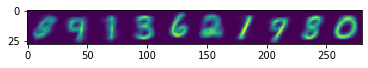

In [14]:
centers = kmeans.cluster_centers().reshape([10, 28, 28])
plt.imshow(np.concatenate([centers[i] for i in range(10)], axis=1))

In [15]:
#again run training on full dataset of 4000
reset()
label_manually(4000)
fit()

Labels: 4000 	Accuracy: 0.9225


In [16]:
#try to run on random 400
reset()
label_manually(400)
fit()

Labels: 400 	Accuracy: 0.8375


In [17]:
#now try to run on 10
reset()
label_manually(10)
fit()

Labels: 10 	Accuracy: 0.38


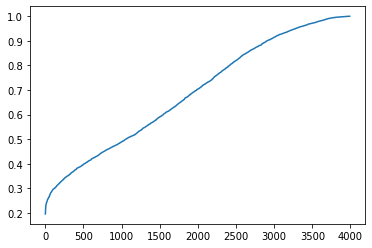

In [18]:
#pass unlabeled rest 3990 through the early model
res = sess.run(y_sm, feed_dict={x:x_unlabeled})
#find less confident samples
pmax = np.amax(res, axis=1)
pidx = np.argsort(pmax)
#sort the unlabeled corpus on the confidency
x_unlabeled = x_unlabeled[pidx]
y_unlabeled = y_unlabeled[pidx]
plt.plot(pmax[pidx])

In [19]:
#do the same in a loop for 400 samples
for i  in range(39):
    label_manually(10)
    fit()
    
    res = sess.run(y_sm, feed_dict={x:x_unlabeled})
    pmax = np.amax(res, axis=1)
    pidx = np.argsort(pmax)
    x_unlabeled = x_unlabeled[pidx]
    y_unlabeled = y_unlabeled[pidx]

Labels: 20 	Accuracy: 0.4975
Labels: 30 	Accuracy: 0.535
Labels: 40 	Accuracy: 0.5475
Labels: 50 	Accuracy: 0.59
Labels: 60 	Accuracy: 0.64
Labels: 70 	Accuracy: 0.6475
Labels: 80 	Accuracy: 0.6925
Labels: 90 	Accuracy: 0.6975
Labels: 100 	Accuracy: 0.73
Labels: 110 	Accuracy: 0.745
Labels: 120 	Accuracy: 0.7625
Labels: 130 	Accuracy: 0.7725
Labels: 140 	Accuracy: 0.7725
Labels: 150 	Accuracy: 0.7725
Labels: 160 	Accuracy: 0.79
Labels: 170 	Accuracy: 0.79
Labels: 180 	Accuracy: 0.7975
Labels: 190 	Accuracy: 0.81
Labels: 200 	Accuracy: 0.81
Labels: 210 	Accuracy: 0.81
Labels: 220 	Accuracy: 0.81
Labels: 230 	Accuracy: 0.81
Labels: 240 	Accuracy: 0.81
Labels: 250 	Accuracy: 0.8125
Labels: 260 	Accuracy: 0.8275
Labels: 270 	Accuracy: 0.8325
Labels: 280 	Accuracy: 0.8325
Labels: 290 	Accuracy: 0.84
Labels: 300 	Accuracy: 0.84
Labels: 310 	Accuracy: 0.8475
Labels: 320 	Accuracy: 0.8475
Labels: 330 	Accuracy: 0.8525
Labels: 340 	Accuracy: 0.8525
Labels: 350 	Accuracy: 0.8525
Labels: 360 	Acc

In [20]:
#pass rest unlabeled data through the model and try to autolabel
res = sess.run(y_sm, feed_dict={x:x_unlabeled})
y_autolabeled = res.argmax(axis=1)
x_labeled = np.concatenate([x_labeled, x_unlabeled])
y_labeled = np.concatenate([y_labeled, y_autolabeled])
#train on 400 labeled by active learning and 3600 stochasticly autolabeled data
fit()

Labels: 4000 	Accuracy: 0.855


In [21]:
#reset the model and train again 400 samples using active learning
reset()
for i in range(40):
    label_manually(10)
    fit()
    
    res = sess.run(y_sm, feed_dict={x:x_unlabeled})
    pmax = np.amax(res, axis=1)
    pidx = np.argsort(pmax)
    x_unlabeled = x_unlabeled[pidx]
    y_unlabeled = y_unlabeled[pidx]

Labels: 10 	Accuracy: 0.38
Labels: 20 	Accuracy: 0.4975
Labels: 30 	Accuracy: 0.535
Labels: 40 	Accuracy: 0.5475
Labels: 50 	Accuracy: 0.59
Labels: 60 	Accuracy: 0.64
Labels: 70 	Accuracy: 0.6475
Labels: 80 	Accuracy: 0.6925
Labels: 90 	Accuracy: 0.6975
Labels: 100 	Accuracy: 0.73
Labels: 110 	Accuracy: 0.745
Labels: 120 	Accuracy: 0.7625
Labels: 130 	Accuracy: 0.7725
Labels: 140 	Accuracy: 0.7725
Labels: 150 	Accuracy: 0.7725
Labels: 160 	Accuracy: 0.79
Labels: 170 	Accuracy: 0.79
Labels: 180 	Accuracy: 0.7975
Labels: 190 	Accuracy: 0.81
Labels: 200 	Accuracy: 0.81
Labels: 210 	Accuracy: 0.81
Labels: 220 	Accuracy: 0.81
Labels: 230 	Accuracy: 0.81
Labels: 240 	Accuracy: 0.81
Labels: 250 	Accuracy: 0.8125
Labels: 260 	Accuracy: 0.8275
Labels: 270 	Accuracy: 0.8325
Labels: 280 	Accuracy: 0.8325
Labels: 290 	Accuracy: 0.84
Labels: 300 	Accuracy: 0.84
Labels: 310 	Accuracy: 0.8475
Labels: 320 	Accuracy: 0.8475
Labels: 330 	Accuracy: 0.8525
Labels: 340 	Accuracy: 0.8525
Labels: 350 	Accura

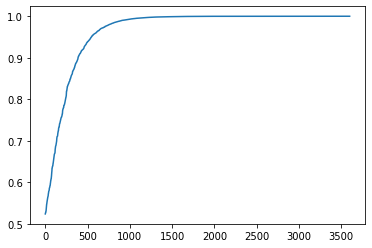

In [22]:
#pass rest of unlabeled (3600) data trough the model for automatic labeling and show most confident samples
res = sess.run(y_sm, feed_dict={x:x_unlabeled})
y_autolabeled = res.argmax(axis=1)
pmax = np.amax(res, axis=1)
pidx = np.argsort(pmax)
#sort by confidency
x_unlabeled = x_unlabeled[pidx]
y_autolabeled = y_autolabeled[pidx]
plt.plot(pmax[pidx])

In [23]:
#automatically label 10 most confident sample and train for it
x_labeled = np.concatenate([x_labeled, x_unlabeled[-10:]])
y_labeled = np.concatenate([y_labeled, y_autolabeled[-10:]])
x_unlabeled = x_unlabeled[:-10]
fit()

Labels: 410 	Accuracy: 0.855


In [24]:
#run rest of unlabelled samples starting from most confident
for i in range(359):
    res = sess.run(y_sm, feed_dict={x:x_unlabeled})
    y_autolabeled = res.argmax(axis=1)
    pmax = np.amax(res, axis=1)
    pidx = np.argsort(pmax)
    x_unlabeled = x_unlabeled[pidx]
    y_autolabeled = y_autolabeled[pidx]
    x_labeled = np.concatenate([x_labeled, x_unlabeled[-10:]])
    y_labeled = np.concatenate([y_labeled, y_autolabeled[-10:]])
    x_unlabeled = x_unlabeled[:-10]
    fit()

Labels: 420 	Accuracy: 0.855
Labels: 430 	Accuracy: 0.855
Labels: 440 	Accuracy: 0.855
Labels: 450 	Accuracy: 0.855
Labels: 460 	Accuracy: 0.855
Labels: 470 	Accuracy: 0.855
Labels: 480 	Accuracy: 0.855
Labels: 490 	Accuracy: 0.855
Labels: 500 	Accuracy: 0.855
Labels: 510 	Accuracy: 0.855
Labels: 520 	Accuracy: 0.855
Labels: 530 	Accuracy: 0.855
Labels: 540 	Accuracy: 0.855
Labels: 550 	Accuracy: 0.855
Labels: 560 	Accuracy: 0.855
Labels: 570 	Accuracy: 0.855
Labels: 580 	Accuracy: 0.855
Labels: 590 	Accuracy: 0.855
Labels: 600 	Accuracy: 0.855
Labels: 610 	Accuracy: 0.855
Labels: 620 	Accuracy: 0.855
Labels: 630 	Accuracy: 0.855
Labels: 640 	Accuracy: 0.855
Labels: 650 	Accuracy: 0.855
Labels: 660 	Accuracy: 0.855
Labels: 670 	Accuracy: 0.855
Labels: 680 	Accuracy: 0.855
Labels: 690 	Accuracy: 0.855
Labels: 700 	Accuracy: 0.855
Labels: 710 	Accuracy: 0.855
Labels: 720 	Accuracy: 0.855
Labels: 730 	Accuracy: 0.855
Labels: 740 	Accuracy: 0.855
Labels: 750 	Accuracy: 0.855
Labels: 760 	A